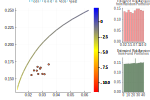

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] plot_asset_sector_withRandomPortfolio(::String) at /home/syu/Documents/Projects/ipo/order_validation/functions.jl:345
 [4] include_string(::String, ::String) at ./loading.jl:522
 [5] softscope_include_string(::Module, ::String, ::String) at /home/syu/.julia/v0.6/SoftGlobalScope/src/SoftGlobalScope.jl:66
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/syu/.julia/v0.6/IJulia/src/execute_request.jl:193
 [7] (::Compat.#inner#6{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/syu/.julia/v0.6/Compat/src/Compat.jl:125
 [8] eventloop(::ZMQ.Socket) at /home/syu/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##13#16)() at ./task.jl:335
while loading In[37], in expression starting on line 146
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /h

In [37]:
# randomly generate a number of porfolios
#using Gadfly

include("functions.jl");

ind=20;

fund_name="VFINX";    

# ----------------------------sector level --------------------------------------------------

#X_obs_sector = CSV.read("../"string(fund_name)"/"string(fund_name)"_X_new.txt", datarow=1);

# load the sector level yearly profit data of VFINX
X_obs_sector = CSV.read("../data/"string(fund_name)"_sector_yearly/"string(fund_name)"_X.txt", datarow=1);


Xobsmat_sector = Matrix(X_obs_sector);
Xobsmat_sector = transpose(Xobsmat_sector);
#Xobsmat_sector = Xobsmat_sector[2:end,:];

A_return_sector = CSV.read("../data/"string(fund_name)"_sector_yearly/"string(fund_name)"_A_"string(ind)".txt", datarow=1);
A_return_sector = Matrix(A_return_sector);
A_return_sector = A_return_sector[size(A_return_sector)[1]-120:size(A_return_sector)[1],:];
#A_return_sector = remove_extreme_negative_return(A_return_sector);

Q_sector = cov(A_return_sector);
ca_sector = mean(A_return_sector,1);

# storages of the efficient frontier
ef_riskvec_sector = Vector{Float64}();
ef_profitvec_sector = Vector{Float64}();

ef_riskvec_fund_sector = Vector{Float64}();
ef_profitvec_fund_sector = Vector{Float64}();

ef_riskvec_random = Vector{Float64}();
ef_profitvec_random = Vector{Float64}();

ef_riskvec_random_onef = Vector{Float64}();
ef_profitvec_random_onef = Vector{Float64}();

# a set of constraints in sector space
dim_sector = 11;

A_sector = -[eye(dim_sector);ones(1,dim_sector);-ones(1,dim_sector);-eye(dim_sector)]; 
b_sector = -[ones(dim_sector,1);1;-1;zeros(dim_sector,1)];
m_sector = length(b_sector);

# draw a EF curve 

steps=logspace(-5,1,100)
# a=range(0.000001,5,300);
# steps = collect(a);

for s in steps
    x_sector=GenerateData(dim_sector,Q_sector,ca_sector,A_sector,b_sector,1,s);
    risk_sector = x_sector'*Q_sector*x_sector;
    profit_sector = x_sector'*ca_sector';
    push!(ef_riskvec_sector, risk_sector[1]);
    push!(ef_profitvec_sector, profit_sector[1]);  
end


# for i=1:size(Xobsmat_sector,1)
#     portfolio_sector = Xobsmat_sector[i,:]./sum(Xobsmat_sector[i,:]);
#     risk_fund_sector = portfolio_sector'*Q_sector*portfolio_sector;
#     profit_fund_sector = portfolio_sector'*ca_sector';
#     push!(ef_riskvec_fund_sector,risk_fund_sector[1]);
#     push!(ef_profitvec_fund_sector,profit_fund_sector[1]);
# end  


rn = 10;
random_porfolios = Vector{Vector{Float64}}(rn);

for loop in 1:rn
    t = rand(11);
    t = t./sum(t);
    random_porfolios[loop]=t;
    risk_rand = t'*Q_sector*t;
    profit_rand = t'*ca_sector';
    push!(ef_riskvec_random, risk_rand);
    push!(ef_profitvec_random, profit_rand[1]);
end


# #----------------------estimation risk aversion factor from random profile------------------------
# all_r = Vector{Float64}();
# M = 100;
# lambda = 100;
# ra_guess = 10;
# tries = 10;

# for loop in 1:rn
#     for t = 1:tries
#         ra_guess, x2 = qp_r_online_ver2(m_sector,11,M,lambda*t^(-1/2),Q_sector,ca_sector',A_sector,b_sector,random_porfolios[loop],ra_guess);
#         print(ra_guess,' ');
#     end
#     push!(all_r, ra_guess);
# end

# #----------------------estimation risk aversion factor from VFINX profile------------------------
# all_fund_r = Vector{Float64}();
# M = 100;
# lambda = 100;
# tries = 10;

# for loop in 1:size(Xobsmat_sector,1)
#     ra_guess =10;
#     portfolio_sector  = Xobsmat_sector[loop,:]./sum(Xobsmat_sector[loop,:]);
#     for t = 1:tries
#         ra_guess, x2 = qp_r_online_ver2(m_sector,11,M,lambda*t^(-1/2),Q_sector,ca_sector',A_sector,b_sector,portfolio_sector,ra_guess);
#     end
#     push!(all_fund_r, ra_guess);
# end


# ---------------generate a series of random risk aversion -----------------------
n_rand=30;
r_rand = rand(Uniform(steps[11],steps[70]),n_rand);   # r_rand is the uniform distributed random risk aversion values
random_porfolios_benchmark = Vector{Vector{Float64}}(n_rand);
all_benchmark_r = Vector{Float64}();

for loop=1:n_rand
    
    x_sector_benchmark=GenerateData(11,Q_sector,ca_sector,A_sector,b_sector,1,r_rand[loop]);
    
    # adding some random noise 
    x_sector_benchmark = x_sector_benchmark +0.005*rand(Float64, 11);
    x_sector_benchmark = x_sector_benchmark./sum(x_sector_benchmark);
    
    
    risk_benchmark = x_sector_benchmark'*Q_sector*x_sector_benchmark;
    profit_benchmark = x_sector_benchmark'*ca_sector';
    push!(ef_riskvec_random_onef, risk_benchmark[1]);
    push!(ef_profitvec_random_onef, profit_benchmark[1]);
    
    ra_guess =1;
    for t = 1:200
        ra_guess, x2 = qp_r_online_ver2(m_sector,11,M,lambda*t^(-1/2),Q_sector,ca_sector',A_sector,b_sector,x_sector_benchmark,ra_guess);
    end    
    push!(all_benchmark_r,ra_guess);
end

plot_asset_sector_withRandomPortfolio("plot5.png");
plot_diagonal_rguess("plot6.png");
plot_rand_portfolio_onef("plot7.png")
